# Programming Exercise 3: Multi-class Classification and Neural Networks
## Machine Learning
## Introduction
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits. Before starting the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics.

Files included in this exercise
* `ex3.ipynb` - Python script that steps you through the exercise  
* `ex3_utils.py` - All necessary functions, classes and solutions for the exercises.
* `ex3_data/ex3data1.mat` - Training set of hand-written digits
* `ex3_data/ex3weights.mat` - Initial weights for the neural network exercise


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ex3_utils import *
import scipy.io as io
import scipy.optimize as opt
from IPython.display import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Multi-class Classification
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.  
In the first part of the exercise, you will extend your previous implemention of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset
You are given a data set in <b>ex3data1.mat</b> that contains 5000 training examples of handwritten digits. The `.mat` format means that that the data has been saved in a native `Octave/MATLAB` matrix format, instead of a text (ASCII) format like a csv-file. These matrices can be read directly into your program by using the <b>scipy.io.loadmat</b> function. The matrix will already be named, so you do not need to assign names to them.

In [2]:
# Load saved matrices from file
data = io.loadmat('ex3_data/ex3data1.mat')
X = data['X']
y = (data['y'])

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (5000, 400)
Shape of y: (5000, 1)


There are 5000 training examples in <b>ex3data1.mat</b>, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. We have mapped the digit zero to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

### 1.2 Visualizing the data  
  
You will begin by visualizing a subset of the training set. In the first part of <b>ex3.ipynb</b>, the code randomly selects selects 100 rows from $X$ and passes those rows to the <b>display_data</b> function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together. After you run this step, you should see an image like <b>Figure 1</b>

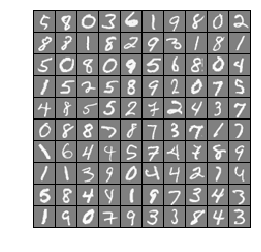

Figure 1: Random 100 examples from the dataset


In [3]:
# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400    #0x20 Input Images of Digits
num_labels = 10            #0 labels, from 1 to 10
                           #note that we have mapped "0" to label 10)
#  =========== Part 1: Visualizing Data =============
m = X.shape[0]

# Randomly select 100 data points to display
randIndices = np.random.randint(0,m,100)
sel = X[randIndices,:]
img = display_data(sel)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
print('Figure 1: Random 100 examples from the dataset')

### 1.3 Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any `for` loops. 

#### 1.3.1 Vectorizing the cost function

We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is:
$$\large{J(\theta) = \frac{1}{m}\sum[-y^{(i)}\log(h_\theta(x^{(i)})-(1-y^{(i)})\log(1-h_\theta(x^{(i)}))]}$$

To compute each element in the summation, we have to compute $h_\theta(x^{(i)})$ for every example $i$, where $h_\theta(x^{(i)})= g(\theta^Tx^{(i)})$ and $g(z)=\frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as
$$
X=\left[ \begin{array}{c}
-(x^{(1)})^T-  \\
-(x^{(1)})^T-   \\
 \vdots      \\
-(x^{(m)})^T-   \\
 \end{array} \right]
\qquad and \qquad 
\theta = \left[\begin{array}{c}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n \\
\end{array} \right].
$$

Then, by computing the matrix product $X\theta$, we have

$$
X  \theta = \left[ \begin{array}{c}
-(x^{(1)})^T\theta -  \\
-(x^{(1)})^T\theta -   \\
 \vdots      \\
-(x^{(m)})^T\theta -   \\
 \end{array} \right]
= \left[ \begin{array}{c}
-\theta^T(x^{(1)})-  \\
-\theta^T(x^{(1)})-   \\
 \vdots      \\
-\theta^T(x^{(m)})-   \\
 \end{array} \right].
$$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^Tx(i)$θ T x (i) for all our examples i in one line of code.
Your job is  to write the unregularized cost function in the file <b>lr_cost_function</b>. Your implementation should use the strategy we presented above to calculate $\theta^Tx(i)$ . You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of <b>lr_cost_function</b> should not contain any loops.
#### 1.3.2 Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^{th}$ element is defined as
$$ \frac{\delta J}{\delta \theta_j} = \frac{1}{m}\sum^{m}_{i=1}{\large((h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j)}$$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,
$$
\left[ \begin{array}{c}
    \frac{\delta J}{\delta \theta_0} \\
    \frac{\delta J}{\delta \theta_1} \\
    \frac{\delta J}{\delta \theta_2} \\
    \vdots \\
    \frac{\delta J}{\delta \theta_n} \\
\end{array}\right] = \frac{1}{m}  
\left[ \begin{array}{c}
    \sum^{m}_{i=1}{(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_0} \\
    \sum^{m}_{i=1}{(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_1} \\
    \sum^{m}_{i=1}{(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_2} \\
    \vdots \\
    \sum^{m}_{i=1}{(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_n} \\
\end{array}\right]  
    =\frac{1}{m} \sum^{m}_{i=1}{((h_\theta(x^{(i)}) - y^{(i)}x^{(i)} )}  
    =\frac{1}{m} X^T(h_\theta(x) - y). 
$$ 

where
$
h_\theta(x) - y =
\left[\begin{array}{c}
    h_\theta(x^{(i)}) - y^{(1)} \\ 
    h_\theta(x^{(i)}) - y^{(2)} \\
    \vdots \\
    h_\theta(x^{(i)}) - y^{(n)})
\end{array}\right]
$

Note that $x^{(i)}$ is a vector, while $(h_\theta(x^{(i)}) - y^{(i)})$ is a scalar (single number). To understand the last step of the derivation, let $\beta_i = (h_\theta(x^{(i)}) - y^{(i)})$ and observe that:
$$
\sum_{i}{\beta_ix^{(i)}} = 
    \left[\begin{array}{cccc}
        \vert &\vert& &\vert \\
        x^{(1)} & x^{(2)} &\cdots & x^{(m)}\\
        \vert &\vert& & \vert 
    \end{array}\right]  
    \left[\begin{array}{c}
        \beta_1 \\
        \beta_2 \\
        \vdots \\
        \beta_m
    \end{array}\right] = X^T\beta, \text{ where the values } \beta_i = (h_\theta(x^{(i)}) - y^{(i)}).
$$
The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplications above to convince yourself that the vectorized version does the same computations. You should now implement above Equation to compute the correct vectorized gradient. Once you
are done, complete the function <b>lr_cost_function</b> by implementing the gradient.
<p style="border:3px; border-style:solid; border-color:#000000; padding: 1em;">
<b>Debugging Tip</b>: Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the size function. For example, given a data matrix $X$ of size $100\times20$ (100 examples, 20 features) and $\theta$, a vector with dimensions $20\times1$, you can observe that $X\theta$ is a valid multiplication operation, while $\theta X$ is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.
</p>  

#### 1.3.3 Vectorizing regularized logistic regression
After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as 

$$\large{J(\theta) = \frac{1}{m}\sum^{m}_{i=1}{[-y^{(i)}\log{(h_\theta(x^{(i)}))} - (1 - y^{(i)})\log{(1 - h_\theta(x^{(i)}))} ]} + \frac{\lambda}{2m} \sum^{n}_{j=1}{\theta^2_j}}
$$

Note that you should not be regularizing $\theta_0$ which is used for the bias term.  
Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as
$$
\large{\left.\begin{array}{lr}
    \frac{\delta J(\theta)}{\delta\theta_0} = \frac{1}{m}\sum^{m}_{i=1}{(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j} & 
    \text{, for } j=0 \\
    \frac{\delta J(\theta)}{\delta\theta_j} = (\frac{1}{m}\sum^{m}_{i=1}{(h_\theta(x^{(i)}) - y^{(i)})x^{(i)}_j}) + 
    \frac{\delta}{m}\theta_j & \text{, for } j \geq 1
\end{array}\right.}
$$

Now modify your code in <b>lr_cost_function</b> to account for regularization.
Once again, you should not put any loops into your code.

In [4]:
# ============ Part 2a: Vectorize Logistic Regression ============
# Test case for lrCostFunction
print('Testing lrCostFunction() with regularization')

theta_t = np.array([[-2], [-1], [1], [2]])
X_t = np.arange(1,16,1).reshape((3,5)).T
X_t = np.append(np.ones((5,1)), X_t/10, axis= 1)
y_t = np.array([[1], [0], [1], [0], [1]])
lambda_t = 3
cost, grad = lr_cost_function(theta_t, X_t, y_t, lambda_t)

print('Cost: %f' %cost)
print('Expected cost: 2.534819\n')
print('Gradients: %0.6f %0.6f %0.6f %0.6f' %tuple(grad))
print('Expected gradients: 0.146561  -0.548558  0.724722  1.398003 ')

Testing lrCostFunction() with regularization
Cost: 2.534819
Expected cost: 2.534819

Gradients: 0.146561 -0.548558 0.724722 1.398003
Expected gradients: 0.146561  -0.548558  0.724722  1.398003 


### 1.4 One-vs-all Classification
In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset (<b>Figure 1</b>). In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$.  
You should now complete the code in <b>one_vs_all</b> to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \mathbb{R}^{K\times(N+1)}$ , where each row of Θ corresponds to the learned logistic regression parameters for one class. You can do this with a “for”-loop from 1 to K, training each classifier independently.
Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped the digit "0" to the label 10 (to avoid confusionswith indexing).  
When training the classifier for class $k \in \{1, ..., K\}$, you will want a m-dimensional vector of labels $y$, where $y_j \in 0, 1$ indicates whether the $j$-th training instance belongs to class $k (y_j = 1)$, or if it belongs to a different class $(y_j = 0)$. You may find logical arrays helpful for this task.

In [5]:
from ex3_utils import *
all_theta = one_vs_all(X, y, 10, 1)

Cost 1:  0.026960
Cost 2:  0.068442
Cost 3:  0.071706
Cost 4:  0.052050
Cost 5:  0.076858
Cost 6:  0.034786
Cost 7:  0.046724
Cost 8:  0.092746
Cost 9:  0.089311
Cost 10:  0.020148


#### 1.4.1 One-vs-all Prediction
After training your one-vs-all classifier, you can now use it to predict thedigit contained in a given image. For each input, you should compute the “probability” that it belongs to each class using the trained logistic regressionclassifiers. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2,..., or K) as the prediction for the input example.  
You should now complete the code in <b>predict_one_vs_all</b> to use the one-vs-all classifier to make predictions.   
Once you are done, the script will call your <b>predict_one_vs_all</b> function using the learned value of $\Theta$. You should see that the training set accuracy is about 94.9% (i.e., it classifies 94.9% of the examples in the training set correctly).

In [6]:
pred = predict_one_vs_all(all_theta, X)
eq = np.equal(pred.reshape((-1,1)),y)
acc = np.mean(eq)*100
print('Training Set Accuracy: %0.2f' %acc)

Training Set Accuracy: 94.46


---
## 2 Neural Networks
In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier.  
In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters.  
The provided script will help you step through this exercise.


In [7]:
# Setup the parameters you will use for this exercise:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   #% 25 hidden units
num_labels = 10          #% 10 labels, from 1 to 10   
# (note that we have mapped "0" to label 10)

### 2.1 Model representation
Our neural network is shown in <b>Figure 2</b>. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20\times20$, this gives us 400 input layer
units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables $X$ and $y$.  
You have been provided with a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ already trained by us. These are stored in <b>ex3weights.mat</b> and will be loaded into <i>Theta1</i> and <i>Theta2</i>. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).  

<b>Figure 2: Neural network model.</b>

<img src="nn.png" align="left" width="45%" height="45%">   

Shape of X: (5000, 400)
Shape of y: (5000, 1)


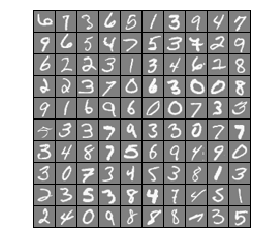

Figure 1: Examples from the dataset


In [8]:
#  =========== Part 1: Loading and Visualizing Data =============
#   We start the exercise by first loading and visualizing the dataset. 
#   You will be working with a dataset that contains handwritten digits.

data = io.loadmat('ex3_data/ex3data1.mat')
X = data['X']
y = (data['y'])
m = X.shape[0]
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)
# Randomly select 100 data points to display
randIndices = np.random.randint(0,m,100)
sel = X[randIndices,:]
img = display_data(sel)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()
print('Figure 1: Examples from the dataset')

In [9]:
#  ================ Part 2: Loading Pameters ================
#  In this part of the exercise, we load some pre-initialized 
#  neural network parameters.

weight = io.loadmat('ex3_data/ex3weights.mat')
# Load the weights into variables Theta1 and Theta2
# load('ex3weights.mat');
Theta1 = weight['Theta1']
Theta2 = weight['Theta2']
print("Theta1's shape:", Theta1.shape)
print("Theta2's shape:", Theta2.shape)

Theta1's shape: (25, 401)
Theta2's shape: (10, 26)


### 2.2 Feedforward Propagation and Prediction
Now you will implement feedforward propagation for the neural network. You will need to complete the code in <b>predict</b> to return the neural network’s prediction.
You should implement the feedforward computation that computes $h_{\theta}(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will
be the label that has the largest output $(h_{\theta}(x))_k$ .
Once you are done, the script will call your predict function using the loaded set of parameters for <i>Theta1</i> and <i>Theta2</i>. You should see that the accuracy is about $97.5\%$. After that, an interactive sequence will launch displaying images from the training set one at a time, while the console prints out the predicted label for the displayed image.

In [10]:
#  ================= Part 3: Implement Predict =================
#   After training the neural network, we would like to use it to predict
#   the labels. The "predict" function to use the neural network to predict 
#    the labels of the training set. This lets#   you compute the training set accuracy.

pred = predict(Theta1, Theta2, X)
eq = np.equal(pred.reshape((-1,1)),y)
acc = (np.sum(eq)/5000)*100
print('Training Set Accuracy: %0.2f' %acc)

Training Set Accuracy: 97.52


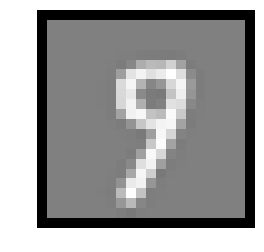

Neural Network Prediction: 9 (digit 9)
Press /r/ to run on another example, /q/ to exit: q


In [11]:
#   To give you an idea of the network's output, you can also run
#   through the examples one at the a time to see what it is predicting.

# %  Randomly permute examples
# rp = randperm(m);
randEx = np.random.randint(0,m,m)
for i in range(m):
    
    ex = randEx[i]
    sel = X[ex:ex+1,:]
    img = display_data(sel)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    Pred = predict(Theta1, Theta2, sel)
    print('Neural Network Prediction: %i' %int(Pred) + ' (digit %i)' %np.mod(int(Pred),10))
    s = input('Press /r/ to run on another example, /q/ to exit: ')
    if s == 'q':
        break
    elif s == 'r':
        clear_output()